In [1]:
import yaml
from scipy.stats import norm, truncnorm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy import units as u
from gammapy.utils.fitting import Parameter, Parameters
from gammapy.stats import wstat
from gammapy.spectrum import SpectrumFit, CrabSpectrum
from gammapy.spectrum.models import SpectralModel

import corner

from tqdm import tqdm
import emcee

from scipy.optimize import minimize
from gammapy.spectrum import CountsPredictor


from utils import load_spectrum_observations, Log10Parabola, plot_spectra

from IPython.display import display, Math
# np.seterr(all='raise')
# from astropy.utils.exceptions import AstropyWarning
# import warnings
# warnings.filterwarnings('error', category=AstropyWarning, append=True)
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

In [7]:
def model_prediction(model, observation):
    predictor = CountsPredictor(model=model, aeff=observation.aeff, edisp=observation.edisp, livetime=observation.livetime)
    predictor.run()
    counts = predictor.npred.data.data
    counts *= observation.on_vector.areascal
    return counts.value

def ln_likelihood(theta, n_on, n_off, alpha):
    mu_s = theta
    mu_b = n_off
    with np.errstate(divide='ignore', invalid='ignore'):
        likelihood_value = -alpha*mu_b - mu_s  + n_on*np.log(alpha*mu_b + mu_s)
    return np.where(mu_s > 0, likelihood_value, -np.inf)
    

def ln_prior(theta):
    '''
    Uninformative poisson prior as far as I know. 
    
    See https://en.wikipedia.org/wiki/Jeffreys_prior
    '''
    mu_sig = theta
#     return np.where(mu_sig >= 0, np.log(np.sqrt(1/(mu_sig))), -np.inf) # jeffreys prior would be nice. but how?
    return np.where(mu_sig >= 0, 0, -np.inf)

def ln_prob(theta, n_on, n_off, alpha, return_posterior=False):
    
    prob = 0.5*ln_likelihood(theta, n_on, n_off, alpha)

    if return_posterior:
        lp = ln_prior(theta)
#         print(f'Mu: {theta}')
#         print(f'prior: {lp}')
        prob = prob + lp
    
    return np.where(np.isfinite(prob), prob, 0)


def apply_range(*arr, fit_range, bins):
    idx = np.searchsorted(bins.to(u.TeV).value, fit_range.to(u.TeV).value )
    return [a[idx[0]:idx[1]] for a in arr]


def model_probability(theta, observations, return_posterior=False, fit_range=None):
    amplitude, alpha, beta = theta
#     print(theta)
    model = Log10Parabola(
        amplitude=amplitude * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
        reference=1 * u.Unit('TeV'),
        alpha=alpha * u.Unit(''),
        beta=beta * u.Unit(''),
    )
    
    obs_probabilities = []
    for obs in observations:
        mu_sig = model_prediction(model, obs)
        obs_alpha = obs.alpha
        n_on=obs.on_vector.data.data.value
        n_off=obs.off_vector.data.data.value
#         print([ln_prob(*d) for d in zip(mu_sig, n_on, n_off, obs.alpha)])
#         prob = sum([ln_prob(*d) for d in zip(mu_sig, n_on, n_off, obs.alpha)])
#         prob = sum([wstat(*d, extra_terms=False) for d in zip(n_on, n_off, alpha, mu_sig)])
        if fit_range is not None:
            bins = obs.on_vector.energy.bins
            mu_sig, n_on, n_off, obs_alpha = apply_range(mu_sig, n_on, n_off, obs_alpha, bins=bins, fit_range=fit_range)

        prob = ln_prob(mu_sig, n_on, n_off, obs_alpha, return_posterior=return_posterior).sum()            
        
#             print([ln_prob(*d) for d in zip()])
#             prob =  sum([ln_prob(*d) for d in zip(mu_sig, n_on, n_off, obs.alpha)])
        obs_probabilities.append(prob)
    return sum(obs_probabilities)
    

In [8]:
obs_list, fit_range = load_spectrum_observations('magic')
fit_range

<Quantity [ 0.08, 30.  ] TeV>

In [9]:
N = 20
betas = np.linspace(0, 0.8, N)
alphas = np.linspace(2.1, 2.8, N)
a, b = np.meshgrid(alphas, betas)

zs = []
zs_post = []
for alpha, beta in tqdm(zip(a.ravel(), b.ravel())):
    zs.append(model_probability([4, alpha, beta], obs_list, fit_range=fit_range))
    zs_post.append(model_probability([4, alpha, beta], obs_list, fit_range=fit_range,  return_posterior=True))

zs = np.array(zs)
zs_post = np.array(zs_post)


400it [00:03, 102.55it/s]


Text(0, 0.5, 'beta')

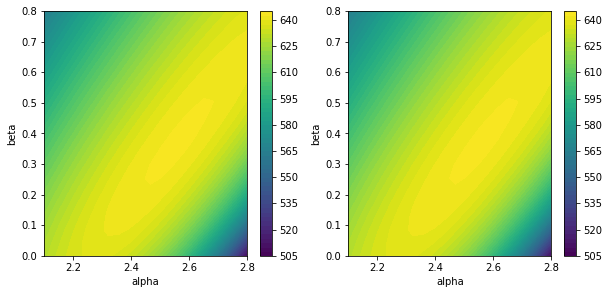

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

cf = ax1.contourf(a, b, zs.reshape(len(a), -1), levels=60)
# ax1.colorbar()
# plt.contour(a, b, zs.reshape(len(a), -1), levels=[0, 1, 2.3],  colors='red')
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

cf = ax2.contourf(a, b, zs_post.reshape(len(a), -1), levels=60 )
plt.colorbar(cf, ax=ax2)
# ax2.colorbar()
# plt.contour(a, b, zs.reshape(len(a), -1), levels=[0, 1, 2.3],  colors='red')
ax2.set_xlabel('alpha')
ax2.set_ylabel('beta')


In [11]:
from scipy.optimize import minimize
result = minimize(lambda *x: -model_probability(*x), x0= [3.8, 2.6, 0.4], args=(obs_list, True, fit_range))
result

      fun: -643.2674364375957
 hess_inv: array([[ 0.15193493, -0.01899123,  0.00215147],
       [-0.01899123,  0.01525163,  0.01421064],
       [ 0.00215147,  0.01421064,  0.01922563]])
      jac: array([ 7.62939453e-06, -7.62939453e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 9
     njev: 12
   status: 0
  success: True
        x: array([4.22454637, 2.53805646, 0.38084355])

In [90]:
import emcee
ndim, nwalkers = 3, 75
pos = np.array([result.x + 0.1 * np.random.randn(ndim) for i in range(nwalkers)])
# print(pos)

from multiprocessing import Pool
with Pool(processes=20) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, model_probability, args=(obs_list, True, fit_range), pool=pool)
    sampler_output = sampler.run_mcmc(pos, 550, progress=True)

100%|██████████| 550/550 [00:50<00:00, 10.89it/s]


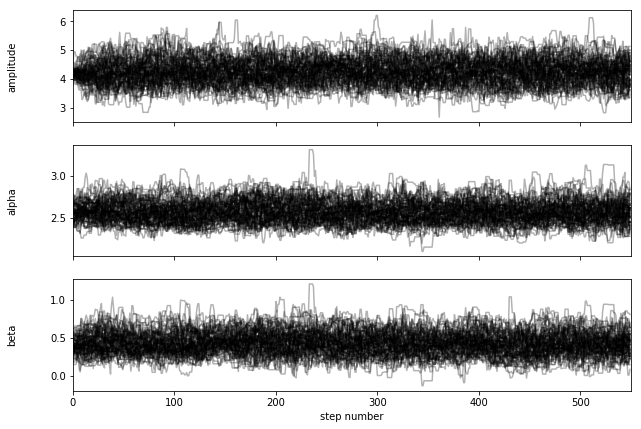

In [91]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = ["amplitude", "alpha", "beta"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i].T, "k", alpha=0.3)
    ax.set_xlim(0, len(sampler.chain[0]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[4.23611675 2.56281425 0.41998343]


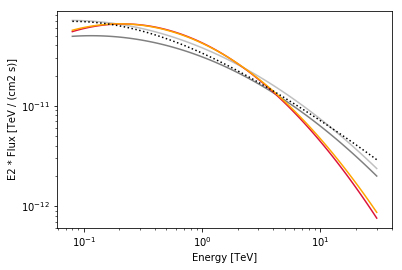

In [93]:
lowest_sample = 50
N = 3
fig = corner.corner(sampler.chain[:, lowest_sample:, :N].reshape([-1, 3]), labels=["$amplitude$", "$\\alpha$", "$\\beta$"])

labels = ["amplitude", "alpha", "beta"]
for i in range(3):
    mcmc = np.percentile(sampler.chain[:, lowest_sample:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

plt.figure(figsize=(10, 8))
plot_spectra(sampler, result, fit_range=fit_range, min_sample=lowest_sample)
plt.legend()

(5e-13, 1e-10)

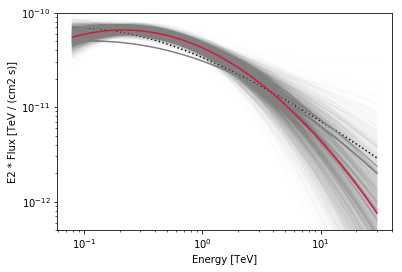

In [94]:
# sampler.chain[:, ::20, :3]
CrabSpectrum(reference='meyer').model.plot(energy_range=fit_range, energy_power=2, color='black', ls=':')
joint_model = Log10Parabola(
    amplitude=3.78 * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=2.49 * u.Unit(''),
    beta=0.22 * u.Unit(''),
)
joint_model.plot(energy_range=fit_range, energy_power=2, color='silver')


fact_model = Log10Parabola(
    amplitude=3.07 * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=2.45 * u.Unit(''),
    beta=0.24 * u.Unit(''),
)
fact_model.plot(energy_range=fit_range, energy_power=2, color='gray')

for r in sampler.chain[:, lowest_sample:, :3].reshape(-1, 3)[::20]:
    fitted_model = Log10Parabola(
        amplitude=r[0] * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
        reference=1 * u.Unit('TeV'),
        alpha=r[1] * u.Unit(''),
        beta=r[2] * u.Unit(''),
    )
    fitted_model.plot(energy_range=fit_range, energy_power=2, color='gray', alpha=0.01)


    
r = np.median(sampler.chain[:, lowest_sample:, :3], axis=(0, 1))
fitted_model = Log10Parabola(
    amplitude=r[0] * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
    reference=1 * u.Unit('TeV'),
    alpha=r[1] * u.Unit(''),
    beta=r[2] * u.Unit(''),
)
fitted_model.plot(energy_range=fit_range, energy_power=2, color='crimson')
plt.ylim([0.5E-12, 1E-10])